#### This project consists of analysing a dataset with a bunch of retail data from a sample store. The goal of the project is to perform time series forecasting on the data, to see if we can accurately predict future daily sales for this store.

#### The model I am using for this project is XGBoost, which is a powerful and robust model that consists of sequentially building decision trees, and using the previous trees loss to learn from its mistakes and try to improve the loss with the next tree.

In [1]:
# Initial imports for the project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import os
import kagglehub


/home/esluter/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
dataset_dir = kagglehub.dataset_download("prasad22/retail-transactions-dataset")

# Extract the files from the directory
files = os.listdir(dataset_dir)
print("Files in dataset: ", files)

# Find the CSV file
csv_file = next((f for f in files if f.endswith(".csv")), None)
if csv_file is None:
    raise FileNotFoundError("No CSV file found in the dataset directory.")

# Create a dataframe for the data
store_sales = pd.read_csv(os.path.join(dataset_dir, csv_file))
print("Dataset loaded successfully")\

# Ensure datetime conversion happens first
store_sales["Date"] = pd.to_datetime(store_sales["Date"])
store_sales["Date"] = store_sales["Date"].dt.date

# Here is a quick overview of the dataset and what kind of data it contains.
print("Dataset Overview:")
print(store_sales.info())

Files in dataset:  ['Retail_Transactions_Dataset.csv']
Dataset loaded successfully
Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Transaction_ID     1000000 non-null  int64  
 1   Date               1000000 non-null  object 
 2   Customer_Name      1000000 non-null  object 
 3   Product            1000000 non-null  object 
 4   Total_Items        1000000 non-null  int64  
 5   Total_Cost         1000000 non-null  float64
 6   Payment_Method     1000000 non-null  object 
 7   City               1000000 non-null  object 
 8   Store_Type         1000000 non-null  object 
 9   Discount_Applied   1000000 non-null  bool   
 10  Customer_Category  1000000 non-null  object 
 11  Season             1000000 non-null  object 
 12  Promotion          666057 non-null   object 
dtypes: bool(1), float64(1), int64(2)

#### Next, we are going to do some feature engineering by adding our own features that are going to help the training process, as well as remove some features that we don't necessarily want.

In [3]:
# Group and analyze
daily_sales = store_sales.groupby("Date")["Total_Cost"].sum().reset_index()
daily_sales.rename(columns={"Total_Cost": "Total_Sales"}, inplace=True)
daily_sales["Date"] = pd.to_datetime(daily_sales["Date"])

# Feature engineering
daily_sales["DayOfWeek"] = daily_sales["Date"].dt.dayofweek
daily_sales["Month"] = daily_sales["Date"].dt.month
daily_sales["Year"] = daily_sales["Date"].dt.year
daily_sales["DayofMonth"] = daily_sales["Date"].dt.day
daily_sales["Quarter"] = daily_sales["Date"].dt.quarter
daily_sales["WeekofYear"] = daily_sales["Date"].dt.isocalendar().week
daily_sales["IsWeekend"] = (daily_sales["DayOfWeek"] >= 5).astype(int)
daily_sales["Discount Applied"] = store_sales["Discount_Applied"].apply(lambda x:1 if x > 0 else 0)


# Create lag features (previous days' sales)
for lag in [1, 2, 3, 7]: # 1, 2, 3, and 7 days ago
    daily_sales[f"Sales_Lag_{lag}"] = daily_sales["Total_Sales"].shift(lag)

# Create rolling window features
for window in [3, 7, 14]:
    daily_sales[f"Sales_Rolling_Mean_{window}"] = daily_sales["Total_Sales"].rolling(
        window=window).mean()
    daily_sales[f"Sales_Rolling_Std_{window}"] = daily_sales["Total_Sales"].rolling(
        window=window).std()
    
daily_sales = daily_sales.dropna().reset_index(drop=True)
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

# Display the first few rows of the processed dataset
display(daily_sales.head())


,Date,Total_Sales,DayOfWeek,Month,Year,DayofMonth,Quarter,WeekofYear,IsWeekend,Discount Applied,Sales_Lag_1,Sales_Lag_2,Sales_Lag_3,Sales_Lag_7,Sales_Rolling_Mean_3,Sales_Rolling_Std_3,Sales_Rolling_Mean_7,Sales_Rolling_Std_7,Sales_Rolling_Mean_14,Sales_Rolling_Std_14
0,2020-01-14,34068.59,1,1,2020,14,1,3,0,0,31332.76,32930.94,34241.83,34234.19,32777.430000,1374.360010,32568.248571,1357.050984,33135.115714,1314.525223
1,2020-01-15,34014.00,2,1,2020,15,1,3,0,1,34068.59,31332.76,32930.94,31230.88,33138.450000,1564.011605,32965.837143,1306.689840,33137.002857,1315.861451
2,2020-01-16,35633.55,3,1,2020,16,1,3,0,0,34014.00,34068.59,31332.76,33107.81,34572.046667,919.693977,33326.657143,1654.782369,33241.894286,1455.260545
3,2020-01-17,32946.98,4,1,2020,17,1,3,0,1,35633.55,34014.00,34068.59,31064.93,34198.176667,1352.721470,33595.521429,1351.083341,33077.192143,1335.739483
4,2020-01-18,31933.14,5,1,2020,18,1,3,1,0,32946.98,35633.55,34014.00,34241.83,33504.556667,1912.178691,33265.708571,1445.505607,33005.800000,1370.322840


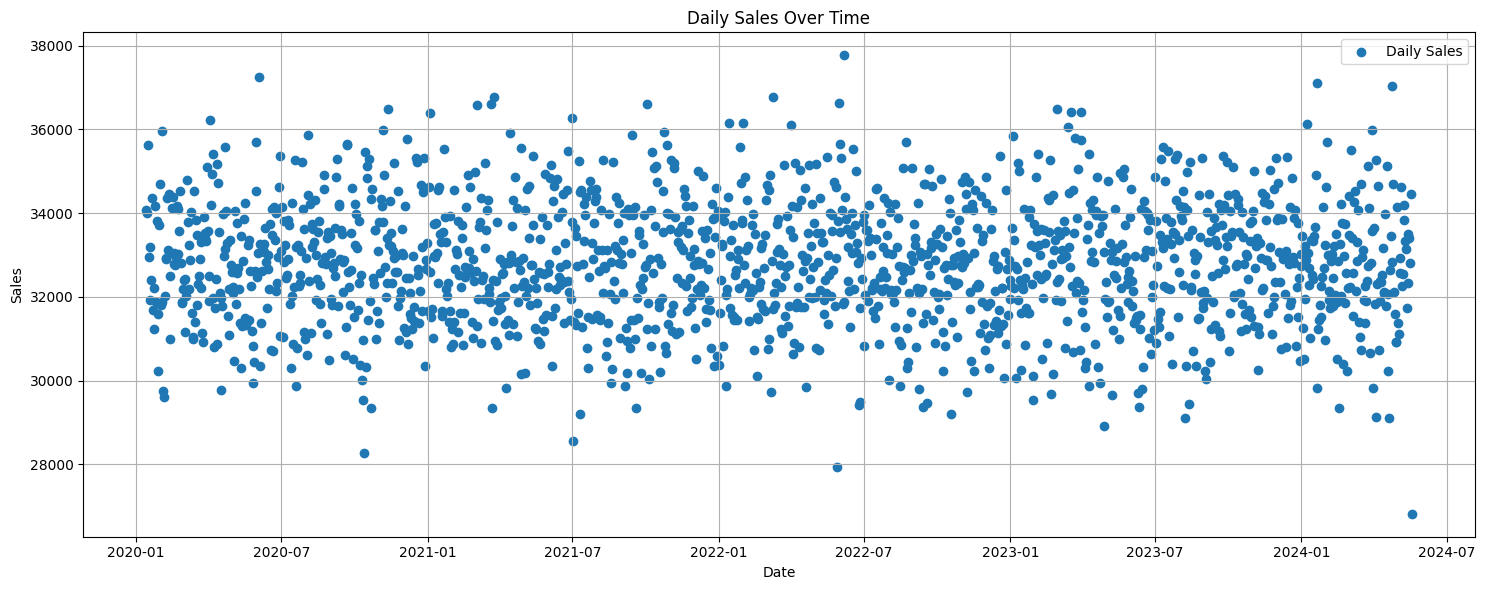

In [4]:
# This plot gives an overview of the daily sales over time, which can help identify trends, seasonality, and anomalies in the data.
plt.figure(figsize=(15, 6))
plt.scatter(daily_sales['Date'], daily_sales["Total_Sales"], label='Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales Over Time')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Next, we want to gather our features and our target that we are trying to predict. The features are going to be everything except the date and the total sales. Since we split up the date into its specific elements, it's not needed. The target is going to be total sales because that is what we are ultimately trying to predict

In [5]:
features = [col for col in daily_sales.columns if col not in ['Date', 'Total_Sales']]
X = daily_sales[features]
y = daily_sales["Total_Sales"]

### Next we are going to split the data, set our hyperparameters, and train the model. Here are the metrics I will be using to evaluate the model:

#### MSE: Measures the average of squared differences between predicted and actual values. It penalizes larger errors more.

#### RMSE: This is just the root of MSE. It is easier to interpret as it is the same unit as the target variable. 

#### R^2_Score: Measures how well your model explains the variance in the actual values. A higher score means your predicted values are very close to the ground truth values. 

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb 


# Split the data using time-based split for time series
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, shuffle = False)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size = 0.5, shuffle = False)


# Initiate and train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators = 800,
    learning_rate = 0.01,
    max_depth = 3,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 1.0,
    reg_alpha = 0.1,
    objective = 'reg:squarederror',
    eval_metric = 'rmse',
    early_stopping_rounds = 10,
    random_state = 42
)

# Train the model
xgb_model.fit(
    X_train, y_train,
    eval_set = [(X_val, y_val)],
    verbose = False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

#### I am now going to run predictions on the model. I decided to run predictions on all splits of the data. By doing this, it will give me a good understanding of how our model is performing, and if it is overfitting or underfitting to the data.

In [7]:
# Making predictions using the x test and train
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
y_valid_pred = xgb_model.predict(X_val)

# Evaluate the model
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

valid_mse = mean_squared_error(y_val, y_valid_pred)
valid_r2 = r2_score(y_val, y_valid_pred)

# Print our results
print(f"Train RMSE: {np.sqrt(train_mse):.2f}")
print(f"Train R²: {train_r2:.4f}")
print(f"{'--'*20}")

print(f"Test RMSE: {np.sqrt(test_mse):.2f}")
print(f"Test R²: {test_r2:.4f}")
print(f"{'--'*20}")

print(f"Validation RMSE: {np.sqrt(valid_mse):.2f}")
print(f"Validation R²: {valid_r2:.4f}")

Train RMSE: 339.59
Train R²: 0.9445
----------------------------------------
Test RMSE: 530.83
Test R²: 0.8835
----------------------------------------
Validation RMSE: 513.05
Validation R²: 0.8728


#### These metrics look great! The loss is low across all three of our data splits, and there isn't a huge gap between the two (suggesting that the model is generalizing well and not overfitting to the data). The R² are great too, and suggest that our model is getting accurate results.

#### Next we will plot the feature importance to see which features are more significant to the training of the model

<Figure size 1000x600 with 0 Axes>

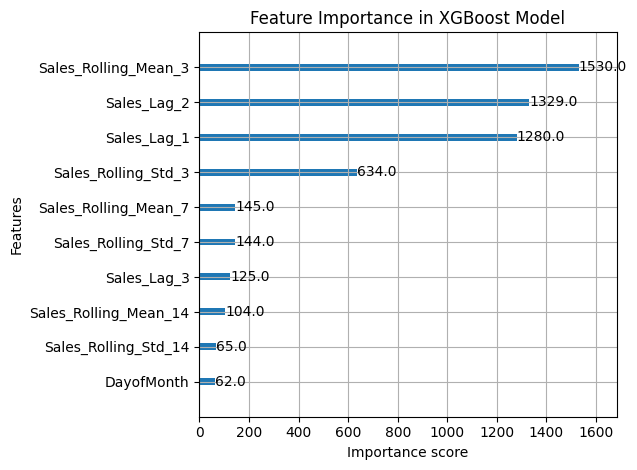

In [8]:
# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.show()

### Next, we're gonna see if the model can accurately predict the sales for the days in the test set. I am going to recreate all of the features that the model was trained on, and feed those into the model so it can make a prediction.

In [9]:
# First step is to gather the dates from X_test and the predictions from y_test_pred to map the predictions to the dates

dates_df = X_test.copy()
dates_df = dates_df.rename(columns = {'DayofMonth': 'Day'})

dates_df['Date'] = pd.to_datetime(dates_df[['Year', 'Month', 'Day']])

dates = [col for col in dates_df.columns if col in ['Date']]
dates_df = dates_df[dates]
dates_df = dates_df


# The results are going to be written to this text file.
with open('results.txt', 'w') as f:

    for i in range(len(X_test.values)):
        target_date = dates_df['Date'].dt.date.iloc[i]

        # Extract features
        target_features = {
            "Month": target_date.month,
            "Year": target_date.year,
            "DayofMonth": target_date.day
        }

        # Filter the matching row in X_test
        mask = (
            (X_test["Month"] == target_features["Month"]) &
            (X_test["Year"] == target_features["Year"]) &
            (X_test["DayofMonth"] == target_features["DayofMonth"])
        )

        # Make sure at least one match exists
        if mask.sum() == 0:
            f.write("No matching row found in X_test for that data.")
        else:
            X_day = X_test[mask]
            y_day = y_test[mask]
            
            # Get our prediction
            predicted_sales = xgb_model.predict(X_day)
            
            # Get the ground truth sales value
            actual_sales = y_day.values

            f.write(f"Predicted sales on {target_date}: ${predicted_sales[0]:.2f}\n")
            f.write(f"Actual sales on {target_date}: ${actual_sales[0]:.2f}\n")
            
            # Percent error
            percent_error = (abs(predicted_sales[0] - actual_sales[0]) / actual_sales[0]) * 100
            f.write(f"Percent error: {percent_error:.2f}%\n\n")

f.close


<function TextIOWrapper.close()>

### The model did great predicting the sales for the days in the testing set. Overall, the models performance was great and could accurately predict totals sales for the sample dataset that was used.

### This project was great practice for exploring EDA and machine learning for a retail dataset. This definitely improved my machine learning and Python skills for data science purposes. I have a decent understanding of how to perform time series forecasting, and will take the skills that I learned to future projects.